# Demo: SVM for MNIST Digit Recognition

In this demo, you will learn to:
* Load and display images
* Formulate image classification problems
* Explain the limitations of linear classifiers for image classification
* Build a simple SVM image classifier 
* Save and load results using `pickle`.

For data, we will use the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set used to recognize hand-written digits.  The dataset was originally produced in the 1980s and is now widely-used in machine learning classes as a simple image classification problem.  

## Loading the Data

First, we load the standard packages.

In [82]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Since the MNIST dataset is so widely-used, it comes in as a build-in dataset in many packages. In this lab, we will download the data from the Tensorflow package -- See here for [installations instructions](https://www.tensorflow.org/install).  You can get the data from other sources as well. 

In the Tensorflow dataset, the training and test data are represented as arrays:

     Xtr.shape = 60000 x 28 x 28
     Xts.shape = 10000 x 28 x 28
     
The test data consists of `60000` images of size `28 x 28` pixels; the test data consists of `10000` images.

In [83]:
import tensorflow as tf

(Xtr,ytr),(Xts,yts) = tf.keras.datasets.mnist.load_data()

print('Xtr shape: %s' % str(Xtr.shape))
print('Xts shape: %s' % str(Xts.shape))

ntr = Xtr.shape[0]
nts = Xts.shape[0]
nrow = Xtr.shape[1]
ncol = Xtr.shape[2]

Xtr shape: (60000, 28, 28)
Xts shape: (10000, 28, 28)


Each pixel value is from `[0,255]`.  For this lab, it will be convenient to recale the value to -1 to 1 and reshape it as a `ntr x npix` and `nts x npix`.

In [84]:
npix = nrow*ncol
Xtr = 2*(Xtr/255 - 0.5)
Xtr = Xtr.reshape((ntr,npix))

Xts = 2*(Xts/255 - 0.5)
Xts = Xts.reshape((nts,npix))

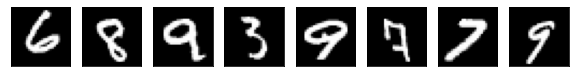

In [86]:
def plt_digit(ax, x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    ax.imshow(xsq,  cmap='Greys_r')
    ax.set_xticks([])
    ax.set_yticks([])

# Select random digits
nplt = 8
Iperm = np.random.permutation(ntr)

# Plot the images using the subplot command
fig, ax = plt.subplots(1,nplt,figsize=(10,3))
for i in range(nplt):
    ind = Iperm[i]
    plt_digit(ax[i], Xtr[ind,:])

## Trying a Logistic Regression Classifier

To classify the digits, we will first use a logistic classifier.  We select a small number of samples for training. Generally, you would use more training samples, but the optimizer is very slow.  

In [11]:
ntr1 = 5000
Xtr1 = Xtr[Iperm[:ntr1],:]
ytr1 = ytr[Iperm[:ntr1]]

Now we run the optimizer.  I have placed the `verbose=10` option so that you can see the progress.  It may not appear in the browser but in the command line where you launched jupyter notebook.  This can take several minutes and will likely say that it ran out of iterations.

In [12]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(verbose=10, solver='lbfgs',\
                                         max_iter=500)
logreg.fit(Xtr1,ytr1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\sdran\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


LogisticRegression(max_iter=500, multi_class='multinomial', verbose=10)

Before continuing, since it takes so long to run the optimizer, let's save the results in a file.  You can use `pickle` module for this purpose.

In [13]:
import pickle

with open( "mnist_logreg.p", "wb" ) as fp:
    pickle.dump( [logreg, Xtr1, ytr1, Iperm],  fp)

Then, we can recover the objects via the `pickle.load` command

In [14]:
with open( "mnist_logreg.p", "rb" ) as fp:
    logreg, Xtr1, ytr1, Iperm = pickle.load(fp)

Now, we can measure the accuracy on the test data.  Again, we will test on a small sub-sample.

In [15]:
nts1 = 5000
Iperm_ts = np.random.permutation(nts) 
Xts1 = Xts[Iperm_ts[:nts1],:]
yts1 = yts[Iperm_ts[:nts1]]
yhat = logreg.predict(Xts1)
acc = np.mean(yhat == yts1)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.887600


You should get an accuracy of around 89%.  This may sounds OK, but it is actually very poor.  Had we increased the number of training samples, it would have improved to about 92%, but that is still very bad.  To illustrate, let's plot some of the errors.  

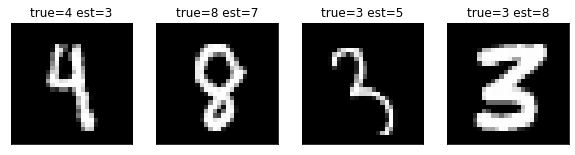

In [16]:
nplt = 4
Ierr = np.where(yts1 != yhat)[0]

fig, ax = plt.subplots(1,nplt,figsize=(10, 4))
for i in range(nplt):        
    ind = Ierr[i]    
    plt_digit(ax[i], Xts1[ind,:])        
    title = 'true={0:d} est={1:d}'.format(yts1[ind].astype(int), yhat[ind].astype(int))
    ax[i].set_title(title)

Obviously, some of these digits are very easy to classify for a human.  We can get more fine-grained analysis of the digit errors by computing the confusion matrix.

[[0.952 0.    0.008 0.    0.002 0.027 0.01  0.    0.002 0.002]
 [0.    0.958 0.006 0.006 0.    0.002 0.    0.    0.033 0.   ]
 [0.01  0.007 0.854 0.019 0.01  0.01  0.014 0.019 0.058 0.004]
 [0.002 0.    0.033 0.871 0.    0.036 0.    0.015 0.041 0.016]
 [0.006 0.002 0.008 0.009 0.878 0.002 0.016 0.01  0.012 0.061]
 [0.006 0.002 0.012 0.043 0.006 0.846 0.012 0.004 0.039 0.002]
 [0.015 0.    0.021 0.002 0.019 0.024 0.92  0.    0.002 0.   ]
 [0.006 0.009 0.019 0.013 0.017 0.002 0.    0.885 0.002 0.049]
 [0.008 0.009 0.023 0.034 0.008 0.036 0.028 0.013 0.831 0.006]
 [0.008 0.006 0.006 0.015 0.031 0.007 0.    0.037 0.014 0.871]]


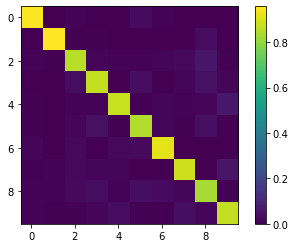

In [17]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(yts1,yhat)

# Normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[None,:]

# Print the confusion matrix
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

## Visualizing the Weights

To see the problem with the logistic classifier, it is useful to plot the weights for each digit.  

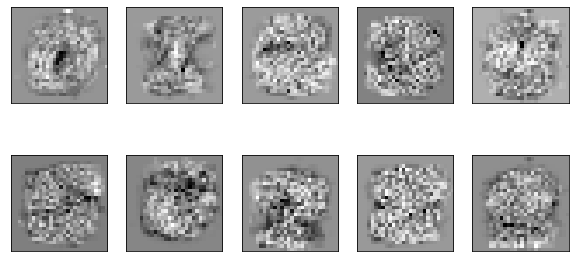

In [97]:
W = logreg.coef_
ndigit = W.shape[0]
fig, ax = plt.subplots(2,5,figsize=(10, 5))
for i in range(ndigit):
    irow = i // 5
    icol = i % 5
    plt_digit(ax[irow,icol], W[i,:])

What you see is that each weight is a very blurry version of the digit.  The blurriness is due to the fact that weight must correlate with all shifts, rotations and other variations of the digits.  As a result, the weights begin to correlate with other incorrect digits leading to poor performance.

To illustrate this problem more clearly, the code below does the following:

*  Takes `nplot=8` random training digits with the label 2 and `nplot=8` that are not the digit 2.
*  Finds a weight `w` to the first of the digits with the label 2.
*  Plots the all the digits `x` and their correlation with the weight `z = w.dot(x)`

We see that the correlation `z` is not consistently higher for the digits 2 instead of the non-digit 2.
Therefore, if we try to use a linear classifier with this weight we would make a lot of errors.

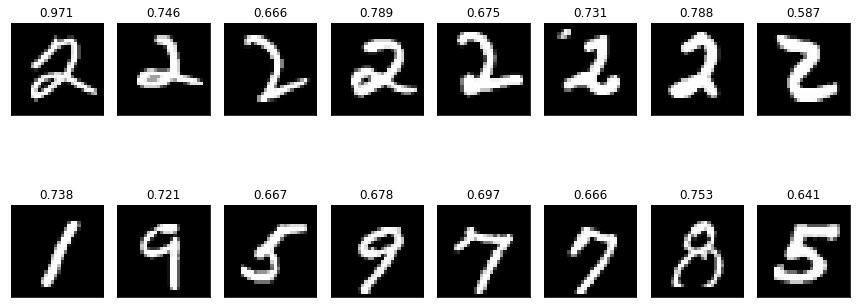

In [110]:
# Find digits with 2 and digits that are not 2
idig = 2
Idig   = np.where(ytr==idig)[0]
Inodig = np.where(ytr!=idig)[0]
n = len(Idig)
Idig = Idig[np.random.permutation(n)]
n = len(Inodig)
Inodig = Inodig[np.random.permutation(n)]

# Set the weight to the first digit
w = Xtr[Idig[0],:]
w = w / np.sum(np.abs(w))

# Find the correlation coefficient with the other digits 7
nplot = 8
fig, ax = plt.subplots(2,nplot,figsize=(12, 6))
rho = np.zeros(nplot)
for i in range(nplot):
    # Get a true and false digit
    j0 = Idig[i]
    j1 = Inodig[i]
    x0 = Xtr[j0,:]
    x1 = Xtr[j1,:]
    
    # Compute the correlations with the two digits
    rho0 = w.dot(x0)
    rho1 = w.dot(x1)
    
    plt_digit(ax[0,i], x0)    
    ax[0,i].set_title('%5.3f' % rho0)
    plt_digit(ax[1,i], x1)
    ax[1,i].set_title('%5.3f' % rho1)

plt.tight_layout()

## In-Class Exercise

Let's try to build a simple linear classifier to detect if a digit is a 2 or not.
*  Set the binary label `q[i] = 1` if `ytr[i] == 2` and `q[i] = 0` if `ytr[i] != 2`.
*  Set the weight `w` = average of `Xtr[i,:]`, the `q[i] == 1`.
*  Plot `w`.  You can use the `plt_digit` command with `ax = plt.gca()`
*  Compute `z[i] = Xtr[i,:].dot(w)`.  This is the linear correlation of the weight with all the training digits.
*  Plot the CDF of `z[i]` for `q[i] = 0` and the CDF of `z[i]` for `q[i] = 1`.
*  Consider the classifier:
    
       qhat[i] = 1,   if z[i] > t
               = 0,   if z[i] <= t
          
   For some threshold `t`.  What does the above CDFs tell you about the accuracy achievable with this classifier.

## Run an SVM classifier

We now try an SVM classifier.  The parameters are given by 

https://martin-thoma.com/svm-with-sklearn/

This website has a nice summary of the main equations for SVM as well.  That site trained on 40000 samples and tested on 20000.  But, to make this run faster, we will train on 10000 and test on 10000.  If you increase to 40000 training samples, you can get past 99% accuracy.

First, we import the SVM package and construct the SVC with the parameters.

## First let us try the linear kernel

In [116]:
from sklearn import svm

# Create a classifier: a support vector classifier
# svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073,verbose=10)
svc = svm.SVC(probability=False,  kernel="linear", C=2.8, gamma=.0073,verbose=10)

Next, we get the training and test data.  The features are re-scaled to be between -1 and 1.

We fit the training data.  Again, this will take several minutes.

In [117]:
ntr1 = 5000
nts1 = 5000
Xtr1 = Xtr[Iperm[:ntr1],:]
ytr1 = ytr[Iperm[:ntr1]]
Xts1 = Xts[Iperm_ts[:nts1],:]
yts1 = yts[Iperm_ts[:nts1]]

In [118]:
svc.fit(Xtr,ytr)

[LibSVM]

SVC(C=2.8, gamma=0.0073, kernel='linear', verbose=10)

Save the results in case you want them without re-running the above the code.

In [119]:
import pickle

with open( "mnist_svc.p", "wb" ) as fp:
    pickle.dump( [svc, Xtr1,ytr1], fp)

We can reload the data

In [120]:
# Can skip this step if you run the classifier directly
import pickle
with open( "mnist_svc.p", "rb" ) as fp:
    svc, Xtr1,ytr1 = pickle.load(fp)

Measure the accuracy on the test data.  The prediction can take several minutes too -- SVMs are *very* slow!

In [121]:
yhat_ts = svc.predict(Xts1)

Since even the prediction (sometimes called inference) is slow with SVMs, we will save the results in `pickle` file. Instead of running the prediction again, you can recapture the data with the following comamnd

In [122]:
with open("mnist_svc_test.p", "wb") as fp:
    pickle.dump([Xts1,yts1,yhat_ts], fp)

In [123]:
with open("mnist_svc_test.p", "rb") as fp:
    Xts1,yts1,yhat_ts = pickle.load(fp)

In [124]:
acc = np.mean(yhat_ts == yts1)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.932600


You should get an accuracy of around 93%.  Again, had you trained on all 50,000 samples, it would have been much better -- close to 98.5%.  But, even this result is much better than logistic regression.

## Looking at the Support Vectors

Let's take a look at the support vectors.  We see there about over 2500 support vectors.  So, about quarter the training samples were used as SVs.  This is partly why the prediction was so slow.

In [125]:
S = svc.support_vectors_
S.shape

(10124, 784)

Let us plot some support vectors

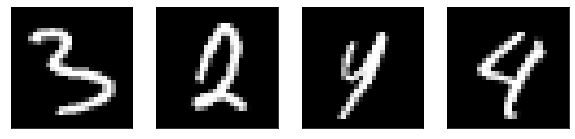

In [126]:
nplt = 4
nsv = S.shape[0]
Iperms = np.random.permutation(nsv)
fig, ax = plt.subplots(1,nplt,figsize=(10, 4))
for i in range(nplt):                
    ind = Iperms[i]
    plt_digit(ax[i], S[ind,:])   

We see that the support vectors look like digits we want to recognize. They are like the 'match filters'.

## Now let us see the performanc of SVM using the RBF kernel

The main benefit of the SVMs is that they can provide nonlinear classification rules.  We can do this with a RBF kernel.  We first fit this as before -- again this will take a long time!  

In [128]:
# Create a classifier: a support vector classifier
svcrbf = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073,verbose=10)

In [129]:
# Can skip this step if loading from previous result 
svcrbf.fit(Xtr1,ytr1)
import pickle
with open( "mnist_svcrbf.p", "wb" ) as fp:
    pickle.dump( [svcrbf, Xtr1, ytr1], fp)
    

[LibSVM]

In [130]:
# Can skip if you run the previous cell
import pickle
with open( "mnist_svcrbf.p", "rb" ) as fp:
    svcrbf, Xtr1, ytr1 = pickle.load(fp)

Make the predictions and save the results and measure the accuracy

In [131]:
# skip if load from saved result
yhat_ts = svcrbf.predict(Xts1)

with open("mnist_svcrbf_test.p", "wb") as fp:
    pickle.dump([yhat_ts,yts1,Xts1], fp)

In [132]:
# skip if you run the previouse cell
with open("mnist_svcrbf_test.p", "rb") as fp:
    yhat_ts,yts1,Xts1 = pickle.load(fp)

In [133]:
acc = np.mean(yhat_ts == yts1)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.961200


We see that the RBF kernel provides more accurate results. 
Now let us plot some errors

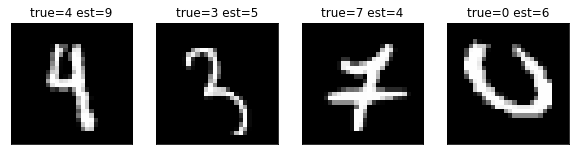

In [134]:
Ierr = np.where((yhat_ts != yts1))[0]
nplt = 4
fig, ax = plt.subplots(1,nplt,figsize=(10, 4))
for i in range(nplt):             
    ind = Ierr[i]    
    plt_digit(ax[i], Xts1[ind,:])        
    title = 'true={0:d} est={1:d}'.format(yts1[ind].astype(int), yhat_ts[ind].astype(int))
    ax[i].set_title(title)

We see that again a human would not have made these errors, but the digits in error are much less clear.

## Looking at the Support Vectors

Let's take a look at the support vectors.  We see there about 5000 support vectors.  So, about half the training samples were used as SVs, more than that for the linear kernel.  This is partly why the prediction was so slow.

In [135]:
S = svcrbf.support_vectors_
S.shape

(3001, 784)

We can plot some of the vectors.

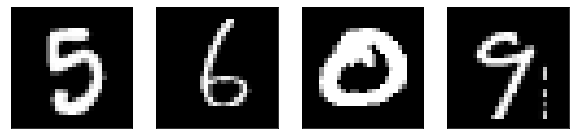

In [136]:
nplt = 4
nsv = S.shape[0]
Iperms = np.random.permutation(nsv)
fig, ax = plt.subplots(1,nplt,figsize=(10, 4))
for i in range(nplt):        
    ind = Iperms[i]
    plt_digit(ax[i], S[ind,:])        

In this demo, we specified the parameters for the SVC. In the lab, you will be asked to find the optimal parameters through cross validation.